In [ ]:
#@title Setting up environment
!sudo rm -rf /usr/local/lib/python3.8/dist-packages/OpenSSL
!sudo rm -rf /usr/local/lib/python3.8/dist-packages/pyOpenSSL-22.1.0.dist-info/

!wget https://repo.anaconda.com/miniconda/Miniconda3-py38_23.5.2-0-Linux-x86_64.sh
!chmod +x Miniconda3-py38_23.5.2-0-Linux-x86_64.sh

!bash ./Miniconda3-py38_23.5.2-0-Linux-x86_64.sh -b -f -p /usr/local
import sys
sys.path.append('/usr/local/lib/python3.8/site-packages/')
!pip3 install pyOpenSSL==22.0.0

In [ ]:
!pip install recommenders[examples]

In [ ]:
from recommenders.datasets.python_splitters import python_stratified_split

In [ ]:
from google.colab import drive
import os
import pandas as pd
import sys
import logging
import scipy
import numpy as np

drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/BT4222 Project')
os.chdir('Datasets/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 300)

# Feature Engineering

In [ ]:
ml_tmdb_merged_df = pd.read_csv('ml_tmdb_merged.csv')

<ipython-input-3-34bceae82eef>:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  ml_tmdb_merged_df = pd.read_csv('ml_tmdb_merged.csv')


In [ ]:
print(list(ml_tmdb_merged_df.columns))

['userId', 'rating', 'timestamp_rated', 'tag', 'ml_title', 'tmdbId', 'cast', 'crew', 'budget', 'homepage', 'keywords', 'original_language', 'original_title', 'overview', 'popularity', 'production_companies', 'production_countries', 'release_date', 'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'vote_average', 'vote_count', 'combined_genres']


In [ ]:
# View original features
ml_tmdb_merged_df.iloc[767470]

userId                                                               1161
rating                                                                2.0
timestamp_rated                                       2015-01-16 08:30:58
tag                                                                   NaN
ml_title                           Machinist, The (Maquinista, El) (2004)
tmdbId                                                               4553
cast                    Christian Bale, Jennifer Jason Leigh, Aitana S...
crew                    Roque Baños, Julio Fernández, Luis de la Madri...
budget                                                            5000000
homepage                                                              NaN
keywords                factory, insomnia, post it, machinist, cleanin...
original_language                                                      en
original_title                                              The Machinist
overview                The Machinist 

## Date Features
release_year

In [ ]:
ml_tmdb_merged_df['release_year'] = pd.to_datetime(ml_tmdb_merged_df['release_date']).dt.year

## One-Hot Encoding

We perform one-hot encoding on the following features to ensure that these categorical features are properly represented in encoded formats that our ML models can work with during model training.

1. *production_countries*
2. *original_language*
3. *spoken_languages*

In [ ]:
ml_tmdb_merged_df['production_countries'].unique()[:20]

array(['United States of America', 'France, United States of America',
       'United Kingdom, United States of America', 'United Kingdom',
       'United States of America, United Kingdom',
       'Germany, United States of America',
       'Canada, United States of America',
       'Australia, United States of America', 'Germany',
       'China, Hong Kong, Taiwan, United States of America',
       'France, United Kingdom, United States of America',
       'France, Germany', 'New Zealand, United States of America',
       'Mexico', 'India, United Kingdom, United States of America',
       'France, Italy, United States of America',
       'Jamaica, United Kingdom', nan,
       'Germany, United Kingdom, United States of America',
       'France, Germany, Italy, United States of America'], dtype=object)

In [ ]:
# One-Hot Encoding on production_countries
countries_df = ml_tmdb_merged_df['production_countries'].str.split(', ', expand=True)
countries_df = pd.get_dummies(countries_df, prefix='production_country_', prefix_sep='')

one_hot_encoded_countries = countries_df.groupby(level=0, axis=1).sum()

ml_tmdb_merged_df = pd.concat([ml_tmdb_merged_df, one_hot_encoded_countries], axis=1)
ml_tmdb_merged_df = ml_tmdb_merged_df.drop('production_countries', axis=1)

In [ ]:
ml_tmdb_merged_df['original_language'].unique()[:20]

array(['en', 'de', 'zh', 'fr', 'es', 'cn', 'pt', 'hi', 'it', 'da', 'ja',
       'ko', 'nb', 'sv', 'xx', 'fa', 'af', 'ru', 'nl', 'he'], dtype=object)

In [ ]:
# One-Hot Encoding on original_language
original_language_df = pd.get_dummies(ml_tmdb_merged_df['original_language'], prefix='original_language_', prefix_sep='')

one_hot_encoded_original_language = original_language_df.groupby(level=0, axis=1).sum()

ml_tmdb_merged_df = pd.concat([ml_tmdb_merged_df, one_hot_encoded_original_language], axis=1)
ml_tmdb_merged_df = ml_tmdb_merged_df.drop('original_language', axis=1)

In [ ]:
ml_tmdb_merged_df['spoken_languages'].unique()[:20]

array(['English', 'English, Deutsch', 'Español, English',
       'Español, English, Français, Magyar', 'English, Français, Latin, ',
       'English, Español', 'English, Français',
       'English, Deutsch, Français', 'English, Español, Français',
       'svenska, English', 'Deutsch, Polski, עִבְרִית, English',
       'English, Italiano, 日本語', 'English, Italiano, Latin',
       'English, Deutsch, Italiano', 'Français, Latin, English',
       'English, Español, Deutsch, עִבְרִית, العربية, ',
       'English, Français, Italiano', 'Deutsch, ελληνικά, English',
       'English, Français, Deutsch, svenska, Italiano, Pусский',
       'English, עִבְרִית, Español, Deutsch'], dtype=object)

In [ ]:
# One-Hot Encoding on spoken_languages
spoken_languages_df = ml_tmdb_merged_df['spoken_languages'].str.split(', ', expand=True)
spoken_languages_df = pd.get_dummies(spoken_languages_df, prefix='spoken_language_', prefix_sep='')

one_hot_encoded_spoken_languages = spoken_languages_df.groupby(level=0, axis=1).sum()

ml_tmdb_merged_df = pd.concat([ml_tmdb_merged_df, one_hot_encoded_spoken_languages], axis=1)
ml_tmdb_merged_df = ml_tmdb_merged_df.drop('spoken_languages', axis=1)

In [ ]:
# Add 'has_homepage' column: 1 if 'homepage' is filled, 0 for null
ml_tmdb_merged_df['has_homepage'] = ml_tmdb_merged_df['homepage'].notna().astype(int)

## Evaluating Financial Success

We attempt to engineer features to evaluate a movie's financial success (which encapsulates other often overlooked factors like the movie's marketing and distribution) through various metrics commonly used in the film industry.

1. *Gross Profit = Revenue - Budget*
2. *Return on Investment = (Revenue - Budget) / Budget*
3. *Profit Margin = (Revenue - Budget) / Revenue*

The purpose of integrating financial metrics is to enhance the model's ability to provide personalized and relevant suggestions to users. For example, we can use popularity score and ROI as filters to exclude movies with low popularity/ROI from the recommendation pool for users who tend to watch only popular movies or even new users (to mitigate cold start problem).

In [ ]:
# Calculate Gross Profit
ml_tmdb_merged_df['gross_profit'] = ml_tmdb_merged_df['revenue'] - ml_tmdb_merged_df['budget']

# Calculate Return on Investment
ml_tmdb_merged_df['roi'] = (ml_tmdb_merged_df['revenue'] - ml_tmdb_merged_df['budget']) / ml_tmdb_merged_df['budget']

# Calculate Profit Margin
ml_tmdb_merged_df['profit_margin'] = (ml_tmdb_merged_df['revenue'] - ml_tmdb_merged_df['budget']) / ml_tmdb_merged_df['revenue']

In [ ]:
# View encoded columns and other engineered features
ml_tmdb_merged_df.iloc[767470]

userId                                                               1161
rating                                                                2.0
timestamp_rated                                       2015-01-16 08:30:58
tag                                                                   NaN
ml_title                           Machinist, The (Maquinista, El) (2004)
tmdbId                                                               4553
cast                    Christian Bale, Jennifer Jason Leigh, Aitana S...
crew                    Roque Baños, Julio Fernández, Luis de la Madri...
budget                                                            5000000
homepage                                                              NaN
keywords                factory, insomnia, post it, machinist, cleanin...
original_language                                                      en
original_title                                              The Machinist
overview                The Machinist 

## Genre Affinity Score

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity

ml_tmdb_merged_df['genres_list'] = ml_tmdb_merged_df['combined_genres'].str.split(',').apply(
    lambda x: [i.strip() for i in x if i != '' and i != '(no genres listed)']
)

mlb = MultiLabelBinarizer()
mlb.fit(ml_tmdb_merged_df['genres_list'])
# Transform the genres list into a binary matrix
genre_encoded = mlb.transform(ml_tmdb_merged_df['genres_list'])

# Create a DataFrame from the encoded genres
genre_df = pd.DataFrame(genre_encoded, columns=mlb.classes_)
ml_tmdb_merged_df = ml_tmdb_merged_df.join(genre_df)

# Aggregate encoded genres for each user
user_genre_matrix = ml_tmdb_merged_df.groupby('userId')[mlb.classes_].sum()

# Calculate the cosine similarity between each user's genre vector and the average genre vector
average_genre_vector = user_genre_matrix.mean(axis=0).values.reshape(1, -1)
genre_affinity_scores = cosine_similarity(user_genre_matrix, average_genre_vector)

In [ ]:
user_genre_affinity_df = pd.DataFrame({
    'userId': user_genre_matrix.index,
    'genre_affinity_score': genre_affinity_scores.flatten()
})
ml_tmdb_merged_df = ml_tmdb_merged_df.merge(user_genre_affinity_df, on='userId', how='left')

In [ ]:
ml_tmdb_merged_df['genre_affinity_score'].describe()

count    829339.000000
mean          0.953087
std           0.046713
min           0.239671
25%           0.939913
50%           0.968305
75%           0.983802
max           0.998877
Name: genre_affinity_score, dtype: float64

## Text based features
Clean Overview feature

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Preprocess the text
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

ml_tmdb_merged_df['overview_clean'] = ml_tmdb_merged_df['overview'].fillna('').apply(preprocess_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Sentiment Analysis of *tagline* and *overview*
We analyze the *tagline* and *overview* columns using the TextBlob and VADER libraries to generate sentiment scores ranging from -1 to 1 (where -1 is the most negative sentiment, 0 is neutral, and 1 is the most positive sentiment).


We then take the average sentiment scores determined by these 2 libraries.

In [ ]:
!pip install textblob

In [ ]:
import spacy
import nltk
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Function to get sentiment polarity using TextBlob
def get_sentiment_textblob(text):
    analysis = TextBlob(str(text))
    return analysis.sentiment.polarity

# Function to get sentiment polarity using VADER
def get_sentiment_vader(text):
    sid = SentimentIntensityAnalyzer()
    sentiment_score = sid.polarity_scores(text)
    return sentiment_score['compound']

In [ ]:
nltk.download('vader_lexicon')

# Sentiment Analysis on 'tagline'
unique_movies = ml_tmdb_merged_df.drop_duplicates(subset=['tmdbId'])
unique_movies = unique_movies.reset_index()
unique_movies['tagline'] = unique_movies['tagline'].astype(str)

# TextBlob
unique_movies['tagline_sentiment_score_textblob'] = unique_movies['tagline'].apply(get_sentiment_textblob)

# VADER
unique_movies['tagline_sentiment_score_vader'] = unique_movies['tagline'].apply(get_sentiment_vader)

# Average sentiment score between TextBlob and VADER
unique_movies['tagline_sentiment_score_average'] = (unique_movies['tagline_sentiment_score_textblob'] + unique_movies['tagline_sentiment_score_vader']) / 2

tagline_sentiment_df = unique_movies[['tmdbId', 'tagline_sentiment_score_textblob', 'tagline_sentiment_score_vader', 'tagline_sentiment_score_average']]
ml_tmdb_merged_df_embed = pd.merge(ml_tmdb_merged_df, tagline_sentiment_df, how="left", on="tmdbId")

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
# Sentiment Analysis on 'overview'
unique_movies['overview'] = unique_movies['overview'].astype(str)

# TextBlob
unique_movies['overview_sentiment_score_textblob'] = unique_movies['overview'].apply(get_sentiment_textblob)

# VADER
unique_movies['overview_sentiment_score_vader'] = unique_movies['overview'].apply(get_sentiment_vader)

# Average sentiment score between TextBlob and VADER
unique_movies['overview_sentiment_score_average'] = (unique_movies['overview_sentiment_score_textblob'] + unique_movies['overview_sentiment_score_vader']) / 2

# Left join back to X_train
overview_sentiment_df = unique_movies[['tmdbId', 'overview_sentiment_score_textblob', 'overview_sentiment_score_vader', 'overview_sentiment_score_average']]
ml_tmdb_merged_df = pd.merge(ml_tmdb_merged_df, overview_sentiment_df, how="left", on="tmdbId")

## Engagement Score

We calculate an engagement score for every unique movie using 3 features - *popularity*, *vote_average* and *vote_count*.

To determine the weights we should assign to each feature, we consider arguments for the importance of each feature — *popularity*, *vote_average*, and *vote_count* — in the context of a movie's engagement score.

1. *popularity*: reflects how well-known and widely viewed a movie is
2. *vote_average*: reflects audience sentiments and overall satisfaction with the movie
3. *vote_count*: reflects the number of people who have expressed their opinion on a movie (i.e reach)

We perform min-max normalization to ensure that each feature is equally represented.

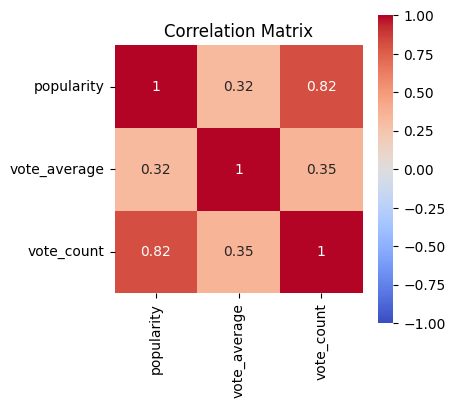

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def normalize(feature):
    return (feature - feature.min()) / (feature.max() - feature.min())

unique_movies['popularity_scaled'] = normalize(unique_movies['popularity'])
unique_movies['vote_average_scaled'] = normalize(unique_movies['vote_average'])
unique_movies['vote_count_scaled'] = normalize(unique_movies['vote_count'])

# Create a DataFrame with the normalized features
normalized_features = pd.DataFrame({
    'popularity': unique_movies['popularity_scaled'],
    'vote_average': unique_movies['vote_average_scaled'],
    'vote_count': unique_movies['vote_count_scaled']
})

# Calculate the correlation matrix
correlation_matrix = normalized_features.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(4, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, square=True)
plt.title('Correlation Matrix')
plt.show()

Since *popularity* and *vote_count* are highly correlated, compared to *vote_average*, we place more importance (weight) on *vote_average* as a measure of the **quality** of a movie as perceived by the audience, whereas *popularity* and *vote_count* focus on the broad **impact and reach**.

In [ ]:
weights = {'popularity': 0.3, 'vote_average': 0.4, 'vote_count': 0.3}

# Calculate the engagement score
unique_movies['engagement_score'] = (
    weights['popularity'] * unique_movies['popularity_scaled'] +
    weights['vote_average'] * unique_movies['vote_average_scaled'] +
    weights['vote_count'] * unique_movies['vote_count_scaled']
)

engagement_df = unique_movies[['tmdbId', 'popularity_scaled', 'vote_average_scaled', 'vote_count_scaled', 'engagement_score']]
ml_tmdb_merged_df = pd.merge(ml_tmdb_merged_df, engagement_df, how="left", on="tmdbId")

In [ ]:
print(list(ml_tmdb_merged_df_embed.columns))

['userId', 'rating', 'timestamp_rated', 'tag', 'ml_title', 'tmdbId', 'cast', 'crew', 'budget', 'homepage', 'keywords', 'original_title', 'overview', 'popularity', 'production_companies', 'release_date', 'revenue', 'runtime', 'status', 'tagline', 'vote_average', 'vote_count', 'combined_genres', 'movie_id', 'overview_embedding', 'production_country_Afghanistan', 'production_country_Angola', 'production_country_Argentina', 'production_country_Aruba', 'production_country_Australia', 'production_country_Austria', 'production_country_Bahamas', 'production_country_Belgium', 'production_country_Bhutan', 'production_country_Bolivia', 'production_country_Bosnia and Herzegovina', 'production_country_Brazil', 'production_country_Bulgaria', 'production_country_Canada', 'production_country_China', 'production_country_Colombia', 'production_country_Czech Republic', 'production_country_Denmark', 'production_country_Dominica', 'production_country_Ecuador', 'production_country_Egypt', 'production_countr

# Train-Test Split (75:25)

In [ ]:
print(ml_tmdb_merged_df.shape)
print(ml_tmdb_merged_df['userId'].nunique(()))
print(ml_tmdb_merged_df['tmdbId'].nunique(()))

(829339, 255)
8656
3973


In [ ]:
# Perform a 75:25 train-test split
X_train, X_test = python_stratified_split(ml_tmdb_merged_df, ratio=0.75, col_user="userId", col_item="tmdbId", seed=42)
X_train = X_train.reset_index()
X_test = X_test.reset_index()

## Handling '0' *budget* or *revenue* values: KNN Imputation

We choose to perform KNN Imputation on the train and test set separately to prevent train-test contamination.

In [ ]:
from sklearn.neighbors import NearestNeighbors
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

# Select relevant features for KNN (Train)
selected_features = X_train[["popularity", "runtime", "vote_average", "vote_count"]]

# Scale selected features
scaler = StandardScaler()
selected_features_train = scaler.fit_transform(selected_features)

knn = NearestNeighbors(n_neighbors=10)

knn.fit(selected_features_train)

# Create a mask to identify rows with non-zero budget and revenue
non_zero_mask = (X_train['budget'] > 0) & (X_train['revenue'] > 0)

# Loop through rows with zero budget and revenue and impute with neighbors' averages
for i in range(len(X_train)):
    if not non_zero_mask[i]:  # Check if it's a row with zero budget and revenue
        neighbor_indices = knn.kneighbors([selected_features_train[i]], return_distance=False)[0]
        neighbor_budgets = X_train['budget'].iloc[neighbor_indices]
        neighbor_revenues = X_train['revenue'].iloc[neighbor_indices]

        # Calculate the average of non-zero budget and revenue values among neighbors
        avg_budget = neighbor_budgets[neighbor_budgets > 0].mean()
        avg_revenue = neighbor_revenues[neighbor_revenues > 0].mean()

        # Impute the values
        X_train.at[i, 'budget'] = avg_budget
        X_train.at[i, 'revenue'] = avg_revenue


# Select relevant features for KNN (Test)
selected_features = X_test[["popularity", "runtime", "vote_average", "vote_count"]]

# Scale selected features
scaler = StandardScaler()
selected_features_test = scaler.fit_transform(selected_features)

knn = NearestNeighbors(n_neighbors=10)

knn.fit(selected_features_test)

# Create a mask to identify rows with non-zero budget and revenue
non_zero_mask = (X_test['budget'] > 0) & (X_test['revenue'] > 0)

# Loop through rows with zero budget and revenue and impute with neighbors' averages
for i in range(len(X_test)):
    if not non_zero_mask[i]:  # Check if it's a row with zero budget and revenue
        neighbor_indices = knn.kneighbors([selected_features_test[i]], return_distance=False)[0]
        neighbor_budgets = X_test['budget'].iloc[neighbor_indices]
        neighbor_revenues = X_test['revenue'].iloc[neighbor_indices]

        # Calculate the average of non-zero budget and revenue values among neighbors
        avg_budget = neighbor_budgets[neighbor_budgets > 0].mean()
        avg_revenue = neighbor_revenues[neighbor_revenues > 0].mean()

        # Impute the values
        X_test.at[i, 'budget'] = avg_budget
        X_test.at[i, 'revenue'] = avg_revenue

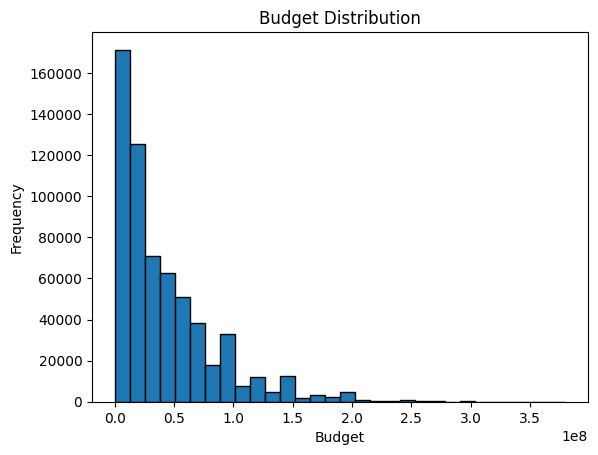

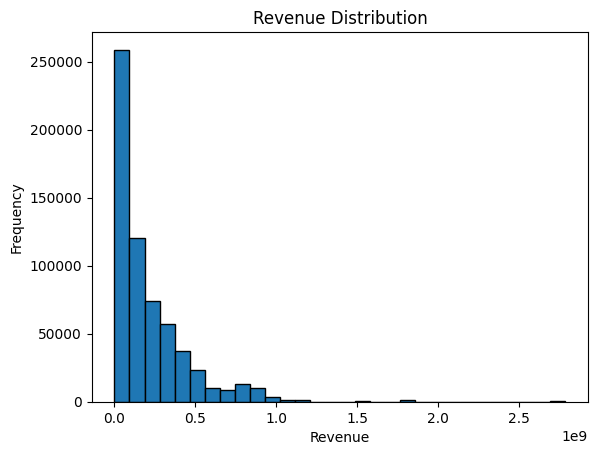

In [ ]:
import matplotlib.pyplot as plt

plt.hist(X_train['budget'], bins=30, edgecolor='k')
plt.xlabel("Budget")
plt.ylabel("Frequency")
plt.title("Budget Distribution")
plt.show()

plt.hist(X_train['revenue'], bins=30, edgecolor='k')
plt.xlabel("Revenue")
plt.ylabel("Frequency")
plt.title("Revenue Distribution")
plt.show()

In [ ]:
X_train = X_train.drop('index', axis=1)
X_test = X_test.drop('index', axis=1)

In [ ]:
list(X_train.columns)

In [ ]:
X_train.to_csv('train_embed.csv', index=False)
X_test.to_csv('test_embed.csv', index=False)

In [ ]:
print(len(X_train))
print(len(X_test))

621955
207384


# Feature Selection



In [ ]:
train = pd.read_csv('train_embed.csv', dtype={'homepage': 'str'})

<ipython-input-2-78cecd1245c4>:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('train_embed.csv', dtype={'homepage': 'str'})


## Filter Methods
1. Correlation Coefficient: remove highly correlated numerical features
- Highly correlated features may provide redundant information, and their presence can lead to multicollinearity issues in some models.
- Removing the highly correlated features can simplify the model, enhance interpretability, and potentially improve generalization to unseen data.
2. Variance Threshold: check independence between categorical variables
- Features with low variance often carry less information and may not significantly contribute to the model's performance.
- It helps to eliminate features that have minimal variability across instances.

In [ ]:
list(train.columns)

### Correlation Coefficient

In [ ]:
import pandas as pd

df_numeric = train[['gross_profit','rating','homepage','overview_clean',
                    'roi','profit_margin', 'runtime','tagline_sentiment_score_average',
                    'engagement_score','overview_sentiment_score_average','overview_embedding','release_year']]

corr_matrix = df_numeric.corr().abs()
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than a threshold (e.g., 0.8)
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

print(to_drop)

<ipython-input-4-88ee4e9906f0>:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_numeric.corr().abs()


[]


<ipython-input-4-88ee4e9906f0>:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


In [ ]:
# Features to drop
to_drop = ['budget', 'revenue','vote_average','vote_count','overview_sentiment_score_textblob', 'popularity',
           'overview_sentiment_score_vader', 'tagline_sentiment_score_textblob','tagline_sentiment_score_vader',
           'tagline_sentiment_score_textblob','tagline_sentiment_score_vader', 'overview_sentiment_score_textblob',
           'vote_count_scaled', 'vote_average_scaled','overview_sentiment_score_vader', 'tagline_sentiment_score_textblob',
           'tagline_sentiment_score_vader','popularity_scaled']

In [ ]:
# Drop highly correlated features
train_reduced = train.drop(to_drop, axis=1)

In [ ]:
list(train_reduced.columns)

### Variance Threshold

In [ ]:
list(train.columns)

In [ ]:
from sklearn.feature_selection import VarianceThreshold

cat_features = ['userId','timestamp_rated','tag','ml_title','tmdbId','cast','production_companies', 'release_date','genres_list',
                'crew','homepage','keywords','original_title','overview','overview_clean','status','tagline', 'combined_genres', 'overview_embedding']

df_numbinary = train_reduced.drop(cat_features, axis=1)
df_numbinary.replace([np.inf, -np.inf], np.nan, inplace=True)

# Assuming a threshold where a feature is removed if 95% of its values are the same
threshold = 0.05 * (1 - 0.05)
sel = VarianceThreshold(threshold=threshold)
reduced_features = sel.fit_transform(df_numbinary)
features_to_keep = sel.get_support(indices=True)
feature_names = df_numbinary.columns[features_to_keep]

feature_names

Index(['rating', 'runtime', 'movie_id', 'production_country_Germany',
       'production_country_United Kingdom',
       'production_country_United States of America', 'genre_Action',
       'genre_Adventure', 'genre_Animation', 'genre_Children', 'genre_Comedy',
       'genre_Crime', 'genre_Drama', 'genre_Family', 'genre_Fantasy',
       'genre_Horror', 'genre_Mystery', 'genre_Romance', 'genre_Sci-Fi',
       'genre_ScienceFiction', 'genre_Thriller', 'genre_War',
       'spoken_language_Deutsch', 'spoken_language_Español',
       'spoken_language_Français', 'spoken_language_Italiano', 'has_homepage',
       'gross_profit', 'roi', 'profit_margin', 'Action', 'Adventure',
       'Animation', 'Children', 'Comedy', 'Crime', 'Drama', 'Family',
       'Fantasy', 'Horror', 'Mystery', 'Romance', 'Sci-Fi', 'ScienceFiction',
       'Thriller', 'War', 'tagline_sentiment_score_average',
       'overview_sentiment_score_average', 'release_year'],
      dtype='object')

#### Reduce on train set

In [ ]:
all_features = df_numbinary.columns
drop_features = list(set(all_features) - set(feature_names))

train_reduced = train_reduced.drop(drop_features, axis=1)

In [ ]:
train_reduced.columns

Index(['userId', 'rating', 'timestamp_rated', 'tag', 'ml_title', 'tmdbId',
       'cast', 'crew', 'homepage', 'keywords', 'original_title', 'overview',
       'production_companies', 'release_date', 'runtime', 'status', 'tagline',
       'combined_genres', 'movie_id', 'overview_embedding',
       'production_country_Germany', 'production_country_United Kingdom',
       'production_country_United States of America', 'genre_Action',
       'genre_Adventure', 'genre_Animation', 'genre_Children', 'genre_Comedy',
       'genre_Crime', 'genre_Drama', 'genre_Family', 'genre_Fantasy',
       'genre_Horror', 'genre_Mystery', 'genre_Romance', 'genre_Sci-Fi',
       'genre_ScienceFiction', 'genre_Thriller', 'genre_War',
       'spoken_language_Deutsch', 'spoken_language_Español',
       'spoken_language_Français', 'spoken_language_Italiano', 'has_homepage',
       'gross_profit', 'roi', 'profit_margin', 'genres_list', 'Action',
       'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Dram

In [ ]:
# drop rest of categorical columns
train_reduced = train_reduced.drop(['overview_clean','homepage', 'combined_genres', 'genres_list'], axis=1)

In [ ]:
train_reduced.to_csv('train_reduced.csv', index=False)

In [ ]:
train_reduced.info()

In [ ]:
train_reduced.describe()

#### Reduce on Test set

In [ ]:
dropped_features = list(set(train) - set(train_reduced))
dropped_features

In [ ]:
test = pd.read_csv('test_embed.csv', dtype={'homepage': 'str'})

In [ ]:
test['release_year']

In [ ]:
test_reduced = test.drop(dropped_features, axis=1)

In [ ]:
test_reduced.to_csv('test_reduced.csv', index=False)

In [ ]:
test = pd.read_csv('test_reduced.csv')
test.columns

Index(['userId', 'rating', 'timestamp_rated', 'tag', 'ml_title', 'tmdbId',
       'cast', 'crew', 'keywords', 'original_title', 'overview',
       'production_companies', 'release_date', 'runtime', 'status', 'tagline',
       'movie_id', 'overview_embedding', 'production_country_Germany',
       'production_country_United Kingdom',
       'production_country_United States of America', 'genre_Action',
       'genre_Adventure', 'genre_Animation', 'genre_Children', 'genre_Comedy',
       'genre_Crime', 'genre_Drama', 'genre_Family', 'genre_Fantasy',
       'genre_Horror', 'genre_Mystery', 'genre_Romance', 'genre_Sci-Fi',
       'genre_ScienceFiction', 'genre_Thriller', 'genre_War',
       'spoken_language_Deutsch', 'spoken_language_Español',
       'spoken_language_Français', 'spoken_language_Italiano', 'has_homepage',
       'gross_profit', 'roi', 'profit_margin',
       'tagline_sentiment_score_average', 'overview_sentiment_score_average',
       'release_year'],
      dtype='object')